In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

import optuna

In [3]:
class BaseModel:
    def __init__(self, learning_rate, weight_decay, units, activation, batch_size, epochs, window_size):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.units = units
        self.activation = activation
        self.batch_size = batch_size
        self.epochs = epochs
        self.window_size = window_size
        self.optimizer = optimizers.Adam(learning_rate=self.learning_rate, weight_decay=self.weight_decay)
        
        self.create_model()
    
    @tf.function
    def loss_fn(self, y_true, y_pred):
        raise NotImplementedError

    def create_model(self):
        raise NotImplementedError
    
    def load_data(self):
        df = pd.read_csv('USDPHP micro_H4 _OHLC.csv', header=None)
        df.columns = ['Open', 'High', 'Low', 'Close']
        df = pd.concat([df.shift(l).add_suffix(f'.L{l:04d}') for l in range(self.window_size + 1)], axis=1)
        df = df.dropna().reset_index(drop=True)
        
        Y = np.array(df[[col for col in df.columns if '.L0000' in col]])
        X = np.array([df[[col for col in df.columns if f'.L{l:04d}' in col]] for l in range(self.window_size, 0, -1)])
        X = X.swapaxes(0, 1)
        
        return X, Y, df
    
    def split_data(self):
        X, Y, df = self.load_data()
        
        n = X.shape[0]
        idx = [0, int(n * 0.6), int(n * 0.8), n]
        X_train, Y_train = X[idx[0]:idx[1]], Y[idx[0]:idx[1]]
        X_val, Y_val = X[idx[1]:idx[2]], Y[idx[1]:idx[2]]
        X_test, Y_test = X[idx[2]: idx[3]], Y[idx[2]:idx[3]]    
    
        return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)    
    
    def fit(self, **kwargs):
        start =  time.time()
        (X_train, Y_train), (X_val, Y_val), _ = self.split_data()     
        self.model.compile(loss=self.loss_fn, optimizer=self.optimizer)
        self.history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                                      epochs=self.epochs, batch_size=self.batch_size, shuffle=True, **kwargs)
        end =  time.time()
        
        if kwargs.get('verbose', True):
            print(f'Time of execution: {end - start}s')
        
        return self.history
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history.history['val_loss'])
        plt.title('Candle Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(loc='best')
        plt.show()

    def plot_train_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history.history['loss'])
        plt.title('Candle Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(loc='best')
        plt.show()
    
    def plot_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Candle Training and Validation Loss')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.legend(loc='best')
        plt.show()

    def mae(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))
    
    def evaluate(self, dataset='test', **kwargs):
        candles = ['Open', 'High', 'Low', 'Close']
        mae_dict = dict()
        
        _, (X_val, Y_val), (X_test, Y_test) = self.split_data()     # Change if no val
        X_true = X_test if dataset == 'test' else X_val
        Y_true = Y_test if dataset == 'test' else Y_val
        
        Y_pred = self.model.predict(X_true, **kwargs)
        for idx, series in enumerate(candles):
            mae = self.mae(Y_true[:, idx], Y_pred[:, idx])
            mae_dict[series] = mae
            
            if kwargs.get('verbose', True):
                print(f'{series} MAE:\t {mae}')
                plt.figure(figsize=(8, 5))
                plt.plot(Y_true[:, idx], label=f'{series} Actual Price')
                plt.plot(Y_pred[:, idx], label=f'{series} Predicted Price')
                plt.title(f'USDPHP {series} Price Plot')
                plt.ylabel('Price')
                plt.xlabel('Time')
                plt.legend(loc='best')
                plt.show()
        
        return mae_dict
    
    def save_pred(self, path=''):
        X_true, Y_true, df = self.load_data()
        Y_pred = self.model.predict(X_true)
        pd.DataFrame(Y_pred, columns=['Open', 'High', 'Low', 'Close']).to_csv(path + self.__class__.__name__ + '.csv')

In [4]:
class FLF_LSTM(BaseModel):
    def __init__(self, kappa, **kwargs):
        self.kappa = kappa
        self.zeta = 1 - kappa
        super().__init__(**kwargs)
        
    @tf.function
    def loss_fn(self, y_true, y_pred):
        alpha = self.zeta * (y_true - y_pred)
        beta = self.kappa * (tf.reduce_mean(y_true[:, 1:3], axis=1) - tf.reduce_mean(y_pred[:, 1:3], axis=1))
        gamma = self.kappa * (tf.reduce_mean(y_true[:, ::3], axis=1) - tf.reduce_mean(y_pred[:, ::3], axis=1))
        
        loss = alpha - tf.math.abs(tf.stack([gamma, beta, beta, gamma], axis=1))
        loss = tf.math.square(loss)
        loss = tf.reduce_mean(loss)
        
        return loss

    def create_model(self):
        self.model = Sequential()
        self.model.add(layers.LSTM(self.units, input_shape=(self.window_size, 4),  activation=self.activation))
        self.model.add(layers.Dense(4))

In [5]:
class OHLC_LSTM(BaseModel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    @tf.function
    def loss_fn(self, y_true, y_pred):
        return tf.reduce_mean(tf.math.pow(y_true - y_pred, 2))
    
    def create_model(self):
        self.model = Sequential()
        self.model.add(layers.LSTM(self.units, input_shape=(self.window_size, 4),  activation=self.activation))
        self.model.add(layers.Dense(4))

In [6]:
class FLF_RNN(BaseModel):
    def __init__(self, kappa, **kwargs):
        self.kappa = kappa
        self.zeta = 1 - kappa
        super().__init__(**kwargs)
        
    @tf.function
    def loss_fn(self, y_true, y_pred):
        alpha = self.zeta * (y_true - y_pred)
        beta = self.kappa * (tf.reduce_mean(y_true[:, 1:3], axis=1) - tf.reduce_mean(y_pred[:, 1:3], axis=1))
        gamma = self.kappa * (tf.reduce_mean(y_true[:, ::3], axis=1) - tf.reduce_mean(y_pred[:, ::3], axis=1))
        
        loss = alpha - tf.math.abs(tf.stack([gamma, beta, beta, gamma], axis=1))
        loss = tf.math.square(loss)
        loss = tf.reduce_mean(loss)
        
        return loss
    
    def create_model(self):
        self.model = Sequential()
        self.model.add(layers.SimpleRNN(self.units, input_shape=(self.window_size, 4),  activation=self.activation))
        self.model.add(layers.Dense(4))

## FLF-LSTM Hyperparameter Optimization

In [7]:
def objective(trial): 
    np.random.seed(trial.number)
    
    kappa = trial.suggest_float('kappa', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-5, log=True)
    units = trial.suggest_categorical('units', [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['elu', 'selu', 'relu'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 500, step=50)
    window_size = trial.suggest_int('window_size', 5, 30, step=5)
    
    model = FLF_LSTM(kappa=kappa, learning_rate=learning_rate, weight_decay=weight_decay, units=units, 
                     activation=activation, batch_size=batch_size, epochs=epochs, window_size=window_size)
    model.fit(verbose=False)
    mae_dict = model.evaluate(dataset='validation', verbose=False)
    val_mae_loss = np.mean(list(mae_dict.values()))
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return val_mae_loss

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print(f'Minimum Average MAE: {trial.value}')
print('Parameters')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-02-28 15:45:40,343] A new study created in memory with name: no-name-1837099e-ccb7-406d-a360-84f8dacd46b8
[I 2024-02-28 15:47:06,636] Trial 0 finished with value: 0.09033297016366656 and parameters: {'kappa': 0.9494352565523543, 'learning_rate': 0.005076120220902839, 'weight_decay': 1.2009914109605042e-10, 'units': 32, 'activation': 'elu', 'batch_size': 128, 'epochs': 450, 'window_size': 10}. Best is trial 0 with value: 0.09033297016366656.
[I 2024-02-28 15:56:07,513] Trial 1 finished with value: 0.19590473439446807 and parameters: {'kappa': 0.37595079893349714, 'learning_rate': 0.00032732582162501884, 'weight_decay': 9.874878887393862e-10, 'units': 256, 'activation': 'selu', 'batch_size': 64, 'epochs': 250, 'window_size': 20}. Best is trial 0 with value: 0.09033297016366656.
[I 2024-02-28 15:59:42,277] Trial 2 finished with value: 0.3773043487443231 and parameters: {'kappa': 0.5878508268423026, 'learning_rate': 0.0002415051676684941, 'weight_decay': 1.876665075728119e-08, 'uni

[I 2024-02-28 16:36:20,523] Trial 24 finished with value: 0.0929659937435819 and parameters: {'kappa': 0.7096389229470581, 'learning_rate': 0.004939600980244405, 'weight_decay': 2.5598491585229646e-10, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 400, 'window_size': 10}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 16:37:51,403] Trial 25 finished with value: 0.13202120757062072 and parameters: {'kappa': 0.8983799605404323, 'learning_rate': 0.0004806527766796156, 'weight_decay': 1.8151421648513476e-09, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 300, 'window_size': 5}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 16:39:41,326] Trial 26 finished with value: 0.13795250042703597 and parameters: {'kappa': 0.7296864982029263, 'learning_rate': 0.005498214110799665, 'weight_decay': 2.9117294083465714e-10, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 200, 'window_size': 15}. Best is trial 19 with value:

[I 2024-02-28 17:57:00,502] Trial 49 finished with value: 0.17052347771463017 and parameters: {'kappa': 0.6024747665673722, 'learning_rate': 0.0011039780592109517, 'weight_decay': 8.215393150615136e-10, 'units': 32, 'activation': 'relu', 'batch_size': 32, 'epochs': 100, 'window_size': 5}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 17:59:01,455] Trial 50 finished with value: 0.09338774672570507 and parameters: {'kappa': 0.7542349446182934, 'learning_rate': 0.004234156704365145, 'weight_decay': 1.8314832240141486e-10, 'units': 64, 'activation': 'relu', 'batch_size': 64, 'epochs': 400, 'window_size': 10}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 18:00:48,623] Trial 51 finished with value: 0.3039262703818686 and parameters: {'kappa': 0.9329478152435535, 'learning_rate': 0.006477057032044941, 'weight_decay': 4.499603636271942e-10, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 350, 'window_size': 5}. Best is trial 19 with value: 0.

[I 2024-02-28 19:10:27,576] Trial 74 finished with value: 0.10660325935088008 and parameters: {'kappa': 0.8455151013723892, 'learning_rate': 0.0056239905171669696, 'weight_decay': 2.3396571350580763e-10, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 400, 'window_size': 15}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 19:11:59,690] Trial 75 finished with value: 0.10621630464164514 and parameters: {'kappa': 0.9535737925398818, 'learning_rate': 0.0076071208111380415, 'weight_decay': 7.986410842945127e-10, 'units': 64, 'activation': 'elu', 'batch_size': 32, 'epochs': 300, 'window_size': 5}. Best is trial 19 with value: 0.06538580213461548.
[I 2024-02-28 19:13:44,964] Trial 76 finished with value: 0.06413153414382147 and parameters: {'kappa': 0.20327353611522103, 'learning_rate': 0.003645935447981116, 'weight_decay': 7.189078926404941e-06, 'units': 16, 'activation': 'relu', 'batch_size': 32, 'epochs': 350, 'window_size': 10}. Best is trial 76 with value:

[I 2024-02-28 19:58:12,673] Trial 99 finished with value: 9.351270553562696 and parameters: {'kappa': 0.16846219069546392, 'learning_rate': 2.8598609252175575e-05, 'weight_decay': 8.675647874115942e-09, 'units': 16, 'activation': 'relu', 'batch_size': 128, 'epochs': 250, 'window_size': 5}. Best is trial 76 with value: 0.06413153414382147.


Minimum Average MAE: 0.06413153414382147
Parameters
kappa: 0.20327353611522103
learning_rate: 0.003645935447981116
weight_decay: 7.189078926404941e-06
units: 16
activation: relu
batch_size: 32
epochs: 350
window_size: 10


In [16]:
trial.params

{'kappa': 0.20327353611522103,
 'learning_rate': 0.003645935447981116,
 'weight_decay': 7.189078926404941e-06,
 'units': 16,
 'activation': 'relu',
 'batch_size': 32,
 'epochs': 350,
 'window_size': 10}

## FLF-LSTM Model Testing

Epoch 1/350
55/55 [==============================] - 2s 9ms/step - loss: 693.3560 - val_loss: 83.3730
Epoch 2/350
55/55 [==============================] - 0s 6ms/step - loss: 10.0835 - val_loss: 0.0945
Epoch 3/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0606 - val_loss: 0.0958
Epoch 4/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0298 - val_loss: 0.0720
Epoch 5/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0295 - val_loss: 0.0910
Epoch 6/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0294 - val_loss: 0.1116
Epoch 7/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0299 - val_loss: 0.1097
Epoch 8/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0995
Epoch 9/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0309 - val_loss: 0.0782
Epoch 10/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0537
Epoch

Epoch 83/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0143 - val_loss: 0.0062
Epoch 84/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0279 - val_loss: 0.0168
Epoch 85/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0089
Epoch 86/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0242 - val_loss: 0.0145
Epoch 87/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0355
Epoch 88/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0343 - val_loss: 0.0120
Epoch 89/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.0153
Epoch 90/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0072
Epoch 91/350
55/55 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0095
Epoch 92/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0473 - val_loss: 0.0085


55/55 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0063
Epoch 246/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0068
Epoch 247/350
55/55 [==============================] - 0s 5ms/step - loss: 0.0230 - val_loss: 0.0119
Epoch 248/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0213
Epoch 249/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 250/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.0060
Epoch 251/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0272 - val_loss: 0.0107
Epoch 252/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0148
Epoch 253/350
55/55 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 254/350
55/55 [==============================] - 0s 5ms/step - loss: 0.0210 - val_loss: 0.0060
Epoc

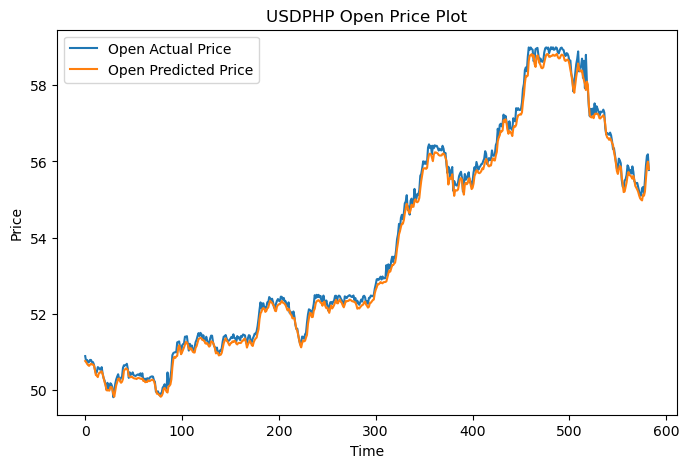

High MAE:	 0.23976946702175234


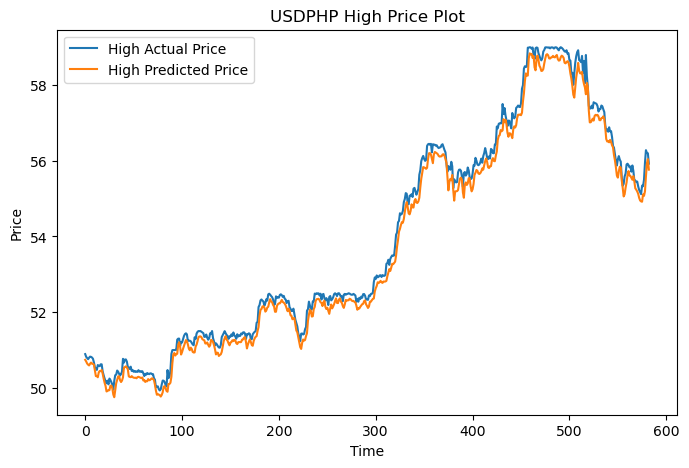

Low MAE:	 0.13891414750951453


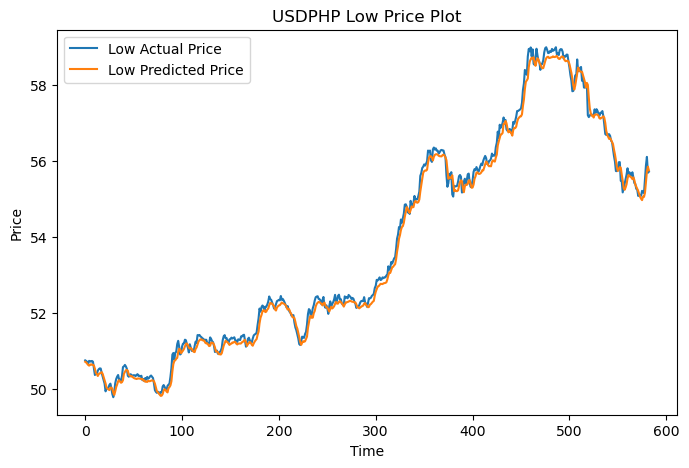

Close MAE:	 0.1696040325393809


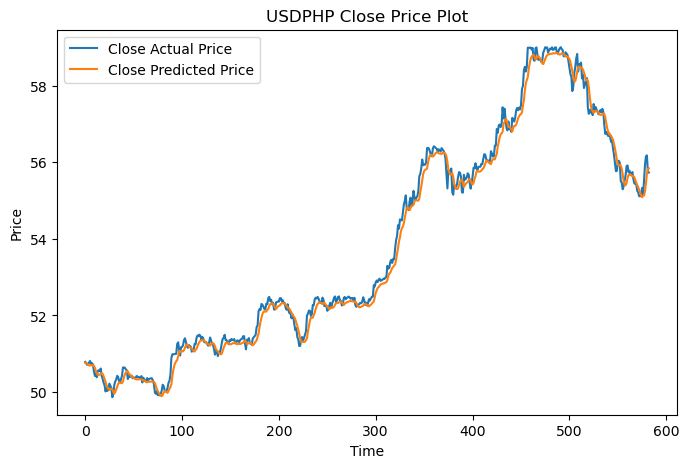

{'Open': 0.13787427658159576,
 'High': 0.23976946702175234,
 'Low': 0.13891414750951453,
 'Close': 0.1696040325393809}

In [15]:
model = FLF_LSTM(**trial.params)
model.fit()
model.evaluate(dataset='test')

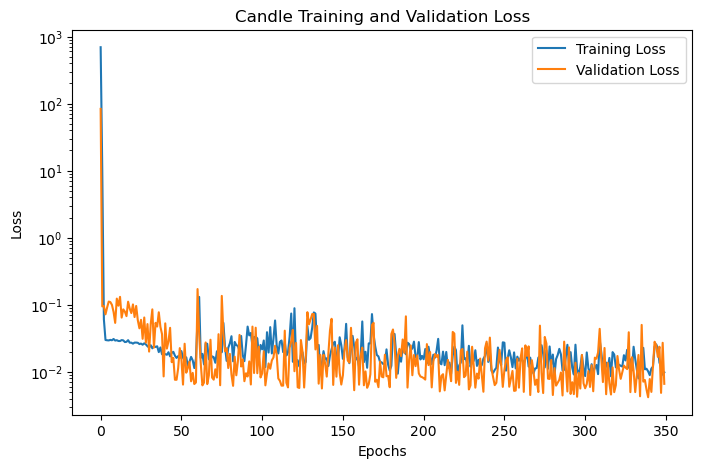

In [17]:
model.plot_loss()

In [18]:
model.save_pred(path="")

91/91 [==============================] - 0s 2ms/step


## OHLC-LSTM Hyperparameter Optimization

In [7]:
def objective(trial): 
    np.random.seed(trial.number)
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-5, log=True)
    units = trial.suggest_categorical('units', [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['elu', 'selu', 'relu'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 500, step=50)
    window_size = trial.suggest_int('window_size', 5, 30, step=5)
    
    OHLC_model = OHLC_LSTM(learning_rate=learning_rate, weight_decay=weight_decay, units=units, 
                     activation=activation, batch_size=batch_size, epochs=epochs, window_size=window_size)
    OHLC_model.fit(verbose=False)
    mae_dict = OHLC_model.evaluate(dataset='validation', verbose=False)
    val_mae_loss = np.mean(list(mae_dict.values()))
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return val_mae_loss

In [8]:
OHLC_study = optuna.create_study(direction='minimize')
OHLC_study.optimize(objective, n_trials=100)

OHLC_trial = OHLC_study.best_trial
print(f'Minimum Average MAE: {OHLC_trial.value}')
print('Parameters')
for key, value in OHLC_trial.params.items():
    print(f'{key}: {value}')

[I 2024-02-29 10:09:23,973] A new study created in memory with name: no-name-b17396fa-943a-40e7-92f6-b78fcb6c371f
[I 2024-02-29 10:10:32,008] Trial 0 finished with value: 0.18676220809125163 and parameters: {'learning_rate': 2.0551469601714913e-05, 'weight_decay': 1.8692975909720067e-06, 'units': 16, 'activation': 'selu', 'batch_size': 32, 'epochs': 200, 'window_size': 5}. Best is trial 0 with value: 0.18676220809125163.
[I 2024-02-29 10:11:50,591] Trial 1 finished with value: 0.09859857551956835 and parameters: {'learning_rate': 0.0030040027074250708, 'weight_decay': 3.2471492845666795e-07, 'units': 32, 'activation': 'relu', 'batch_size': 128, 'epochs': 250, 'window_size': 25}. Best is trial 1 with value: 0.09859857551956835.
[I 2024-02-29 10:12:53,235] Trial 2 finished with value: 0.2792852452816023 and parameters: {'learning_rate': 0.0008701679178818387, 'weight_decay': 2.8032996729324017e-07, 'units': 16, 'activation': 'relu', 'batch_size': 128, 'epochs': 200, 'window_size': 30}. B

[I 2024-02-29 13:29:53,713] Trial 27 finished with value: 0.16172183950947974 and parameters: {'learning_rate': 0.0023004545512549765, 'weight_decay': 2.0515965697706435e-07, 'units': 128, 'activation': 'relu', 'batch_size': 64, 'epochs': 350, 'window_size': 25}. Best is trial 7 with value: 0.0776642611006246.
[I 2024-02-29 13:33:12,536] Trial 28 finished with value: 0.15369989861966 and parameters: {'learning_rate': 0.0001772218037518325, 'weight_decay': 7.845730149039014e-06, 'units': 32, 'activation': 'elu', 'batch_size': 32, 'epochs': 450, 'window_size': 15}. Best is trial 7 with value: 0.0776642611006246.
[I 2024-02-29 13:33:57,324] Trial 29 finished with value: 0.13525732347282293 and parameters: {'learning_rate': 3.08066763849611e-05, 'weight_decay': 2.457433834664687e-06, 'units': 128, 'activation': 'selu', 'batch_size': 128, 'epochs': 150, 'window_size': 5}. Best is trial 7 with value: 0.0776642611006246.
[I 2024-02-29 13:56:01,986] Trial 30 finished with value: 0.146118411794

[I 2024-02-29 15:48:13,560] Trial 54 finished with value: 0.08383974427897838 and parameters: {'learning_rate': 5.662443448490567e-05, 'weight_decay': 1.7162110314051611e-06, 'units': 64, 'activation': 'selu', 'batch_size': 32, 'epochs': 450, 'window_size': 15}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 15:51:56,207] Trial 55 finished with value: 0.1264801866721451 and parameters: {'learning_rate': 0.00021070415247830926, 'weight_decay': 8.116346545176771e-07, 'units': 64, 'activation': 'selu', 'batch_size': 32, 'epochs': 500, 'window_size': 10}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 15:57:06,647] Trial 56 finished with value: 0.07845978636749844 and parameters: {'learning_rate': 0.0001098218513604246, 'weight_decay': 5.112389599978351e-07, 'units': 64, 'activation': 'selu', 'batch_size': 32, 'epochs': 500, 'window_size': 15}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 16:00:45,231] Trial 57 finished with value: 0.

[I 2024-02-29 17:17:07,331] Trial 81 finished with value: 0.06875824210165299 and parameters: {'learning_rate': 0.00012184608650857492, 'weight_decay': 5.829726451474272e-07, 'units': 64, 'activation': 'elu', 'batch_size': 32, 'epochs': 500, 'window_size': 5}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 17:19:11,256] Trial 82 finished with value: 0.05679200564036033 and parameters: {'learning_rate': 0.00015195324852248997, 'weight_decay': 3.2853448455269223e-06, 'units': 64, 'activation': 'elu', 'batch_size': 32, 'epochs': 500, 'window_size': 5}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 17:21:01,992] Trial 83 finished with value: 0.05627163738165672 and parameters: {'learning_rate': 0.00015913729783368749, 'weight_decay': 3.141583926446026e-06, 'units': 64, 'activation': 'elu', 'batch_size': 32, 'epochs': 450, 'window_size': 5}. Best is trial 51 with value: 0.051584482369963706.
[I 2024-02-29 17:22:56,978] Trial 84 finished with value: 0.057

Minimum Average MAE: 0.051584482369963706
Parameters
learning_rate: 0.0002448213963051386
weight_decay: 1.0377103749137857e-06
units: 64
activation: selu
batch_size: 32
epochs: 500
window_size: 10


## OHLC-LSTM Model Testing

In [9]:
OHLC_trial.params

{'learning_rate': 0.0002448213963051386,
 'weight_decay': 1.0377103749137857e-06,
 'units': 64,
 'activation': 'selu',
 'batch_size': 32,
 'epochs': 500,
 'window_size': 10}

Epoch 1/500
55/55 [==============================] - 2s 10ms/step - loss: 516.0847 - val_loss: 10.8827
Epoch 2/500
55/55 [==============================] - 0s 7ms/step - loss: 1.5801 - val_loss: 0.4347
Epoch 3/500
55/55 [==============================] - 0s 7ms/step - loss: 0.1043 - val_loss: 0.3640
Epoch 4/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0854 - val_loss: 0.2986
Epoch 5/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0762 - val_loss: 0.2516
Epoch 6/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0706 - val_loss: 0.2321
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0654 - val_loss: 0.2596
Epoch 8/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0587 - val_loss: 0.1402
Epoch 9/500
55/55 [==============================] - 0s 8ms/step - loss: 0.0430 - val_loss: 0.0381
Epoch 10/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0290
Epoch

Epoch 83/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0216 - val_loss: 0.0153
Epoch 84/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0181 - val_loss: 0.0150
Epoch 85/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0242 - val_loss: 0.0143
Epoch 86/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.0209
Epoch 87/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.0115
Epoch 88/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0242
Epoch 89/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0202
Epoch 90/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0567
Epoch 91/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0161
Epoch 92/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0326


55/55 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 246/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0145 - val_loss: 0.0119
Epoch 247/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0242
Epoch 248/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0126
Epoch 249/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0082
Epoch 250/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0071
Epoch 251/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0074
Epoch 252/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0063
Epoch 253/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0092
Epoch 254/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0072
Epoc

55/55 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0079
Epoch 408/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0071
Epoch 409/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 410/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0120 - val_loss: 0.0069
Epoch 411/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0116
Epoch 412/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0066
Epoch 413/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0097
Epoch 414/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0080
Epoch 415/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 416/500
55/55 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0054
Epoc

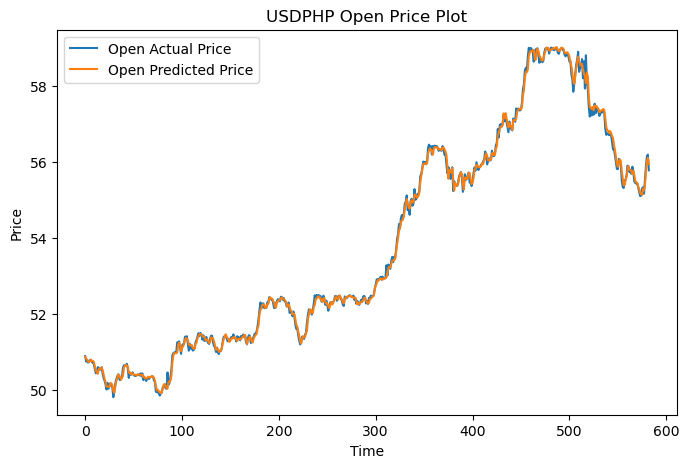

High MAE:	 0.09109351826532007


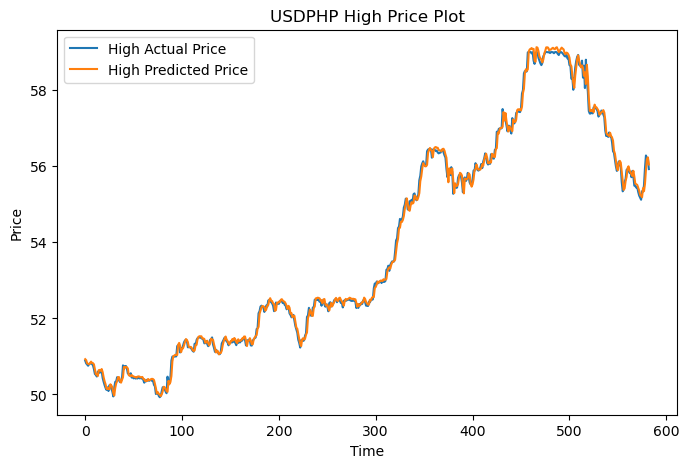

Low MAE:	 0.08445893422776186


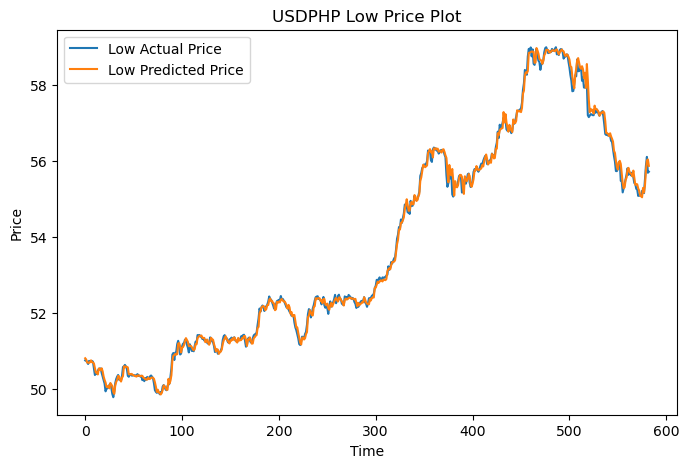

Close MAE:	 0.1177294648630132


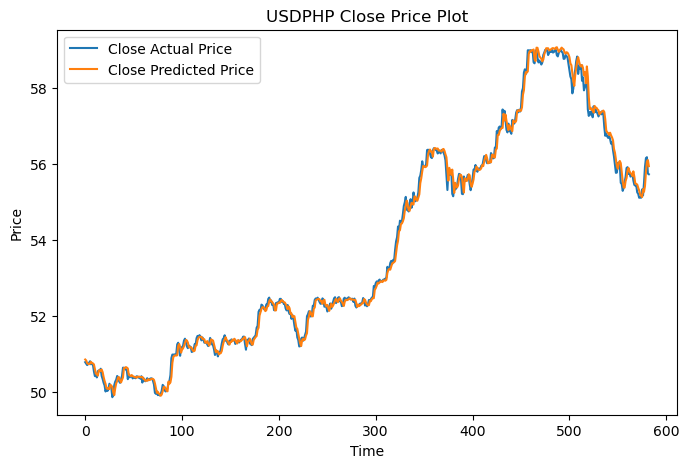

{'Open': 0.0698418607891731,
 'High': 0.09109351826532007,
 'Low': 0.08445893422776186,
 'Close': 0.1177294648630132}

In [10]:
OHLC_LSTM_model = OHLC_LSTM(**OHLC_trial.params)
OHLC_LSTM_model.fit()
OHLC_LSTM_model.evaluate(dataset='test')

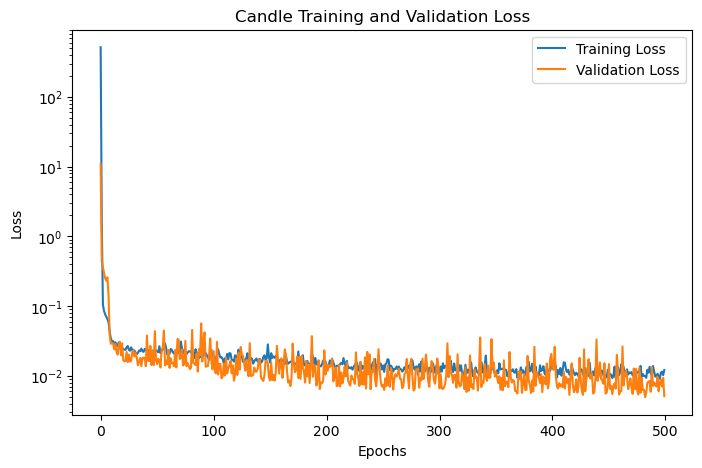

In [11]:
OHLC_LSTM_model.plot_loss()

In [12]:
OHLC_LSTM_model.save_pred(path="")

91/91 [==============================] - 0s 3ms/step


## FLF-RNN Hyperparameter Optimization

In [14]:
def objective(trial): 
    np.random.seed(trial.number)
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-5, log=True)
    units = trial.suggest_categorical('units', [16, 32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['elu', 'selu', 'relu'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 500, step=50)
    window_size = trial.suggest_int('window_size', 5, 30, step=5)
    
    RNN_model = FLF_RNN(kappa=0.20327353611522103, learning_rate=learning_rate, weight_decay=weight_decay, units=units, 
                     activation=activation, batch_size=batch_size, epochs=epochs, window_size=window_size)
    RNN_model.fit(verbose=False)
    mae_dict = RNN_model.evaluate(dataset='validation', verbose=False)
    val_mae_loss = np.mean(list(mae_dict.values()))
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    return val_mae_loss

In [15]:
RNN_study = optuna.create_study(direction='minimize')
RNN_study.optimize(objective, n_trials=100)

RNN_trial = RNN_study.best_trial
print(f'Minimum Average MAE: {RNN_trial.value}')
print('Parameters')
for key, value in RNN_trial.params.items():
    print(f'{key}: {value}')

[I 2024-02-29 18:05:59,425] A new study created in memory with name: no-name-e7edee55-5cc0-4ffe-bd2d-64a47e627931
[I 2024-02-29 18:08:00,393] Trial 0 finished with value: 0.058829609630447324 and parameters: {'learning_rate': 0.00040660628429419447, 'weight_decay': 1.8394435696932718e-06, 'units': 32, 'activation': 'elu', 'batch_size': 32, 'epochs': 400, 'window_size': 5}. Best is trial 0 with value: 0.058829609630447324.
[I 2024-02-29 18:10:17,122] Trial 1 finished with value: 0.07540690357602875 and parameters: {'learning_rate': 0.0010758781818118828, 'weight_decay': 2.0264325719860848e-07, 'units': 64, 'activation': 'elu', 'batch_size': 64, 'epochs': 400, 'window_size': 20}. Best is trial 0 with value: 0.058829609630447324.
[I 2024-02-29 18:12:42,456] Trial 2 finished with value: 0.09185603253865976 and parameters: {'learning_rate': 6.772356949464383e-05, 'weight_decay': 1.0047524282740839e-08, 'units': 32, 'activation': 'elu', 'batch_size': 32, 'epochs': 400, 'window_size': 10}. Be

[I 2024-02-29 18:58:55,915] Trial 26 finished with value: 0.06522607012172577 and parameters: {'learning_rate': 0.00015213429732750835, 'weight_decay': 3.802284003869337e-06, 'units': 32, 'activation': 'relu', 'batch_size': 32, 'epochs': 350, 'window_size': 15}. Best is trial 18 with value: 0.05420857175629718.
[I 2024-02-29 19:00:35,541] Trial 27 finished with value: 0.10278957849351811 and parameters: {'learning_rate': 0.0001466104648409854, 'weight_decay': 2.6479431243847146e-06, 'units': 128, 'activation': 'relu', 'batch_size': 32, 'epochs': 250, 'window_size': 10}. Best is trial 18 with value: 0.05420857175629718.
[I 2024-02-29 19:02:34,718] Trial 28 finished with value: 0.07960063180547228 and parameters: {'learning_rate': 0.00030667851964946333, 'weight_decay': 3.3028321196956822e-06, 'units': 32, 'activation': 'relu', 'batch_size': 32, 'epochs': 450, 'window_size': 5}. Best is trial 18 with value: 0.05420857175629718.
[I 2024-02-29 19:05:10,960] Trial 29 finished with value: 0.

[I 2024-02-29 19:51:11,787] Trial 53 finished with value: 0.26772729017644403 and parameters: {'learning_rate': 0.003044050293105204, 'weight_decay': 1.555784523737003e-06, 'units': 256, 'activation': 'elu', 'batch_size': 32, 'epochs': 250, 'window_size': 10}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 19:52:05,757] Trial 54 finished with value: 0.11857423327594845 and parameters: {'learning_rate': 0.0023192380166658522, 'weight_decay': 8.36373635318386e-07, 'units': 16, 'activation': 'elu', 'batch_size': 32, 'epochs': 200, 'window_size': 5}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 19:55:05,138] Trial 55 finished with value: 0.12683248850242373 and parameters: {'learning_rate': 0.005112504714572996, 'weight_decay': 2.0054897108507818e-06, 'units': 256, 'activation': 'elu', 'batch_size': 64, 'epochs': 400, 'window_size': 10}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 19:55:57,332] Trial 56 finished with value: 0.09168838

[I 2024-02-29 20:53:12,278] Trial 80 finished with value: 0.09370367522247888 and parameters: {'learning_rate': 0.003006223926903029, 'weight_decay': 2.4407933497483197e-07, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 350, 'window_size': 15}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 20:55:48,191] Trial 81 finished with value: 0.0615631917930511 and parameters: {'learning_rate': 0.0011535206213091522, 'weight_decay': 3.118351276128953e-07, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 400, 'window_size': 15}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 20:58:43,901] Trial 82 finished with value: 0.06859591908545173 and parameters: {'learning_rate': 0.0013705231880262849, 'weight_decay': 1.8591328819280163e-07, 'units': 64, 'activation': 'relu', 'batch_size': 32, 'epochs': 450, 'window_size': 15}. Best is trial 37 with value: 0.05417620677882455.
[I 2024-02-29 21:01:20,668] Trial 83 finished with value: 0.0671

Minimum Average MAE: 0.05323469993867075
Parameters
learning_rate: 0.0035145809095634088
weight_decay: 2.240012040324043e-07
units: 64
activation: relu
batch_size: 32
epochs: 250
window_size: 15


## FLF-RNN Model Testing

In [16]:
RNN_trial.params

{'learning_rate': 0.0035145809095634088,
 'weight_decay': 2.240012040324043e-07,
 'units': 64,
 'activation': 'relu',
 'batch_size': 32,
 'epochs': 250,
 'window_size': 15}

Epoch 1/250
55/55 [==============================] - 3s 14ms/step - loss: 79.0943 - val_loss: 0.0762
Epoch 2/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0364 - val_loss: 0.0058
Epoch 3/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 4/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0051
Epoch 5/250
55/55 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 6/250
55/55 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0049
Epoch 7/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 8/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 9/250
55/55 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 10/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 1

Epoch 83/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0154
Epoch 84/250
55/55 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0084
Epoch 85/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 86/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 87/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 88/250
55/55 [==============================] - 0s 7ms/step - loss: 0.3456 - val_loss: 0.0530
Epoch 89/250
55/55 [==============================] - 0s 7ms/step - loss: 0.1193 - val_loss: 0.0049
Epoch 90/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 91/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 92/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0041


55/55 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 246/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0122
Epoch 247/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 248/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 249/250
55/55 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0040
Epoch 250/250
55/55 [==============================] - 0s 8ms/step - loss: 0.0335 - val_loss: 0.1881
Time of execution: 106.6326105594635s
19/19 [==============================] - 0s 3ms/step
Open MAE:	 0.8894754777626483


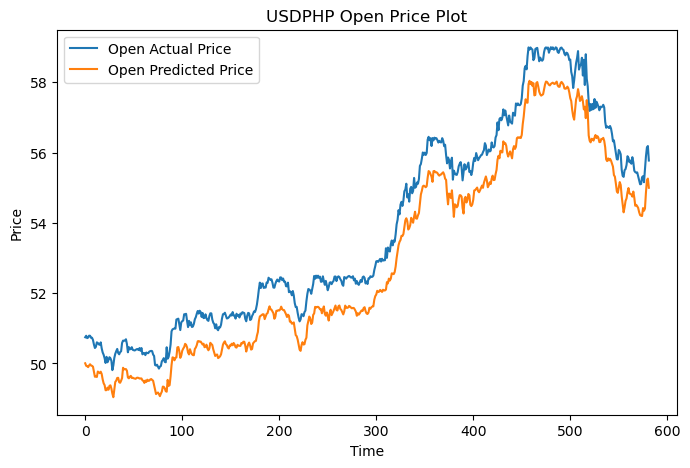

High MAE:	 0.8741403913465152


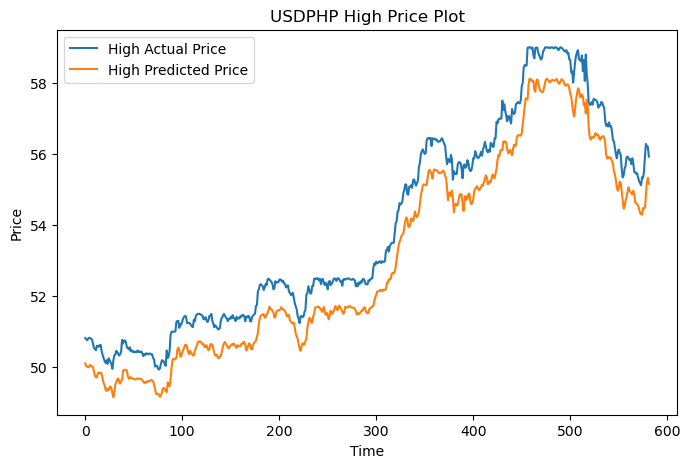

Low MAE:	 0.7336749485186286


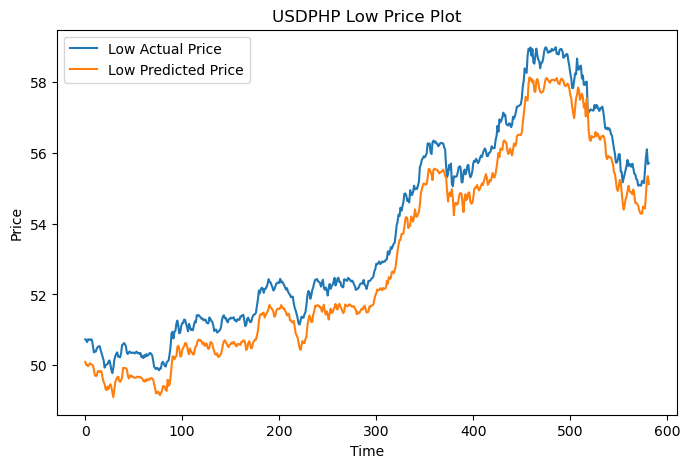

Close MAE:	 0.8148977053403037


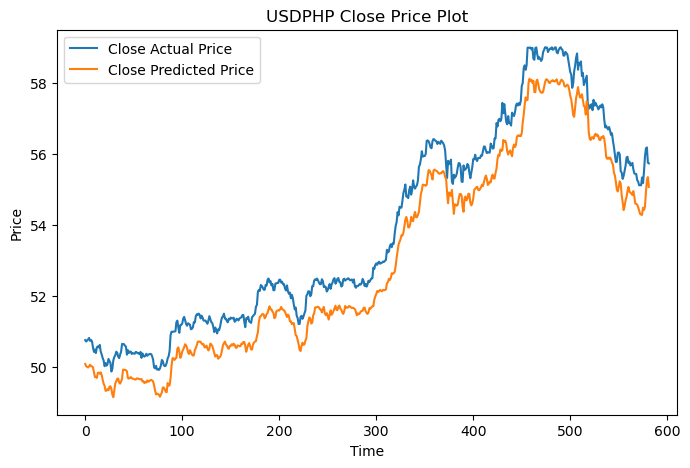

{'Open': 0.8894754777626483,
 'High': 0.8741403913465152,
 'Low': 0.7336749485186286,
 'Close': 0.8148977053403037}

In [17]:
RNN_model = FLF_RNN(kappa=0.20327353611522103,**RNN_trial.params)
RNN_model.fit()
RNN_model.evaluate(dataset='test')

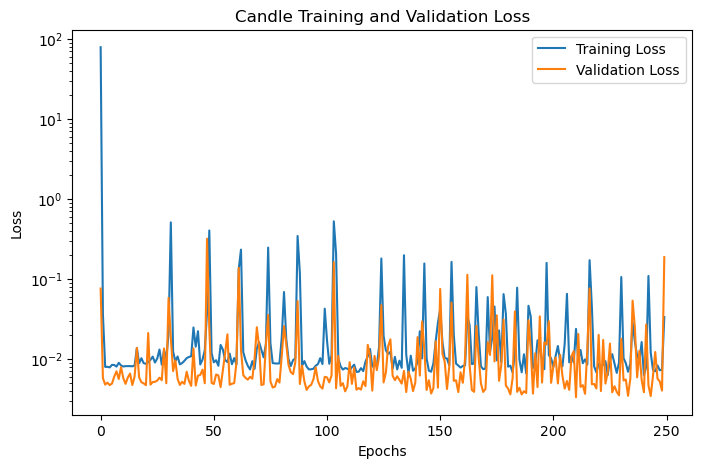

In [18]:
RNN_model.plot_loss()

In [19]:
RNN_model.save_pred(path="")

91/91 [==============================] - 0s 3ms/step
